In [4]:
from os import listdir
from os.path import isfile, join

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
BUZZpath = join("D:","Stack","Courses","KTH","Courses","05 - Scalable Machine Learning","Final Project","BUZZ1")


In [8]:
beefiles = [f for f in listdir(join(BUZZpath,"bee")) if isfile(join(BUZZpath, "bee",f))]
cricketfiles = [f for f in listdir(join(BUZZpath,"cricket")) if isfile(join(BUZZpath, "cricket",f))]
noisefiles = [f for f in listdir(join(BUZZpath,"noise")) if isfile(join(BUZZpath, "noise",f))]

In [9]:
beefiles[:3]

['bee1000_192_168_4_6-2017-08-29_09-15-01.wav',
 'bee1001_192_168_4_6-2017-08-29_09-15-01.wav',
 'bee1002_192_168_4_6-2017-08-29_09-15-01.wav']

In [10]:
from scipy.io import wavfile
sample_rate, samples = wavfile.read(join(BUZZpath, "bee",beefiles[0]))
# sample_rate, samples = wavfile.read(join(BUZZpath, "cricket",cricketfiles[0]))
# sample_rate, samples = wavfile.read(join(BUZZpath, "noise",noisefiles[0]))

In [11]:
sample_rate

44100

In [12]:
samples

array([440, 443, 446, ..., 447, 456, 459], dtype=int16)

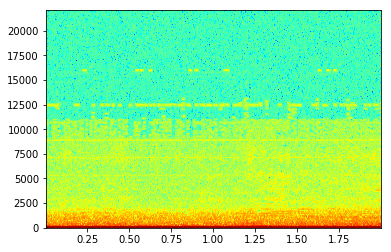

In [13]:
# https://matplotlib.org/api/_as_gen/matplotlib.pyplot.specgram.html

spectrum, freqs, t, im = plt.specgram(samples, NFFT=512, Fs=sample_rate, Fc=0, detrend=plt.mlab.detrend_none,
         window=plt.mlab.window_hanning, noverlap=384,
         cmap='jet', xextent=None, pad_to=None, sides='default',
         scale_by_freq=True, mode='default', scale='default')
# cmap='jet'
# cmap='gray'
# cmap=None

In [14]:
len(freqs)

257

In [15]:
import numpy as np
np.shape(spectrum)

(257, 686)

In [16]:
#im.write_png("bee1001.png")
# im.figure.savefig("bee1001.png", dpi=300)

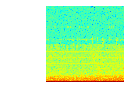

In [24]:
im.figure.set_size_inches(200/144,200/144)
im.figure.frameon = False
im.figure.axes[0].set_axis_off()
display(im.figure)

In [22]:
im.get_size()

(257, 686)

In [381]:
fig = plt.figure(frameon=False)
fig.set_size_inches(200/144,200/144)

<Figure size 100x100 with 0 Axes>

In [382]:
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

In [383]:
# image = spectrum * 255.0/spectrum.max()
image = np.log(spectrum)/np.max(np.log(spectrum))
#image = spectrum
#print(np.min(image))
image -= np.min(image)
#print(np.min(image))

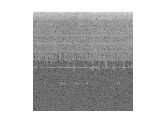

In [384]:
# ax.imshow(spectrum, aspect='auto')
ax.imshow(image, cmap='gray', aspect='auto')
display(fig)
fig.savefig("fname.png")

In [385]:
np.max(np.log(spectrum)), np.min(np.log(spectrum))

(7.938696153829568, -27.316484516100136)

In [386]:
np.min(image), np.max(image)

(0.0, 4.440928332157274)

In [387]:
np.min(np.log(spectrum)/np.max(np.log(spectrum))), np.min(image)

(-3.4409283321572732, 0.0)

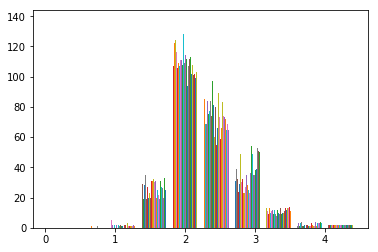

In [388]:
# plt.hist(image);

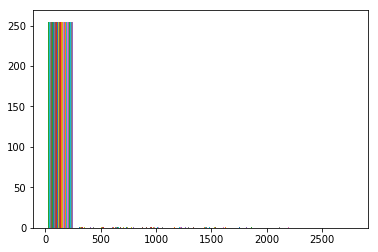

In [389]:
# plt.hist(spectrum);

In [1]:
import tensorflow as tf

In [2]:
# https://github.com/dhoman01/bee-audio-classifier/blob/master/cnn.py

class CNN(object):
    """A CNN to classify bee hive spectrorams"""
    def __init__(self, N=256, num_classes=3):
        self.N = N
        self.num_classes = num_classes
        self.x = tf.placeholder(tf.float32, shape=[None, N], name='input_spectrogram')
        self.y_ = tf.placeholder(tf.float32, shape=[None, num_classes], name='audio_class')

    def _weight_variable(self, shape, name=''):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial, name=name)

    def _bias_variable(self, shape, name=''):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial, name=name)

    def _conv2d(self, x, W):
        return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

    def _max_pool_2x2(self, x):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    def build(self):
        with tf.variable_scope("model", initializer=tf.random_uniform_initializer()) as scope:
            input_layer = tf.add(tf.matmul(self.x, self._weight_variable([self.N,1024], 'input_layer')), self._bias_variable([1024], 'input_bias')) 
            input_layer = tf.reshape(input_layer, [-1, 32, 32, 1])
            
            W_conv1 = self._weight_variable([5, 5, 1, 32], 'input_conv_weights')
            b_conv1 = self._bias_variable([32], 'input_conv_bias')
            
            h_conv1 = tf.nn.relu(self._conv2d(input_layer, W_conv1) + b_conv1)
            h_pool1 = self._max_pool_2x2(h_conv1)

            W_conv2 = self._weight_variable([5, 5, 32, 64], 'hidden_1_weights')
            b_conv2 = self._bias_variable([64], 'hidden_1_bias')

            h_conv2 = tf.nn.relu(self._conv2d(h_pool1, W_conv2) + b_conv2)
            h_pool2 = self._max_pool_2x2(h_conv2)

            W_conv3 = self._weight_variable([5, 5, 64, 128], 'hidden_2_weights')
            b_conv3 = self._bias_variable([128], 'hidden_2_bias')

            h_conv3 = tf.nn.relu(self._conv2d(h_pool2, W_conv3) + b_conv3)
            h_pool3 = self._max_pool_2x2(h_conv3)

            W_fc1 = self._weight_variable([1024 * 2, 1024], 'fc_1_weights')
            b_fc1 = self._bias_variable([1024], 'fc_1_bias')

            h_pool3_flat = tf.reshape(h_pool3, [-1, 1024 * 2])
            h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)

            self.keep_prob = tf.placeholder(tf.float32, name='keep_prob')
            h_fc1_drop = tf.nn.dropout(h_fc1, self.keep_prob)

            W_fc2 = self._weight_variable([1024, self.num_classes], 'fc_2_weights')
            b_fc2 = self._bias_variable([self.num_classes], 'fc_2_bias')

            self.logits = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

        with tf.variable_scope("training", initializer=tf.random_uniform_initializer()) as scope:
            cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.y_, logits=self.logits))
            self.train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

            self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.y_, 1))
            self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

        self.saver = tf.train.Saver()
